# Imports

In [1]:
from datetime import timedelta
import numpy as np
import pandas as pd
import netCDF4 as nc

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from icedef import iceberg, metocean, drift_simulation, plot, tools
from icedef.turnbull import drift

from scipy.optimize import minimize
from scipy.interpolate import RegularGridInterpolator as RGI
from scipy.interpolate import interp1d

# Functions

In [2]:
def create_berg_from_beacon_data(berg_id='204980'):
    #berg_ids = ['204980', '505190', '906790', '907780']

    df = pd.read_csv(f'ftp://data.munroelab.ca/pub/iceberg/beacon/0{berg_id}_2015.csv')

    df['DataDate_UTC'] = pd.to_datetime(df['DataDate_UTC'])

    times = [t.to_pydatetime() for t in df['DataDate_UTC']]

    max_hr = 6
    dt_vec = np.asarray([(time - times[0]).days*24 + (time - times[0]).seconds/3600 for time in times])
    max_hr_indx = np.where(dt_vec < max_hr)[0][-1]

    df = df[:max_hr_indx+1]

    times = [t.to_pydatetime() for t in df['DataDate_UTC']]
    lons = df['Longitude']
    lats = df['Latitude']

    n = 100

    lonn = lons[n]; lon0 = lons[0] 
    latn = lats[n]; lat0 = lats[0]

    dx, dy = tools.deg2m(lon0, lonn, lat0, latn) 
    dist = np.sqrt(dx**2 + dy**2)
    tn = times[n]; t0 = times[0]
    dt = (tn - t0).days*3600 + (tn - t0).seconds
    vx0 = dx/dt; vy0 = dy/dt

    ref_berg = iceberg.Iceberg('0204980_2015', t0, lon0, lat0, vx0, vy0, 'LG', 'TAB')
    ref_berg.history['t'] = times; ref_berg.history['x'] = lons; ref_berg.history['y'] = lats
    
    return ref_berg

In [3]:
def get_tstep_info(dt_hrs):
    dt = dt_hrs*3600
    t0 = ref_berg.history['t'][0]
    tf = ref_berg.history['t'][-1]
    tdelta = tf - t0
    tdelta_secs = tdelta.days*24*3600 + tdelta.seconds
    nt = int(tdelta_secs//dt)
    return dt, nt

In [4]:
def calc_mse(sim_x, sim_y, sim_t, ref_xvec, ref_yvec, ref_tvec):
    t_units = 'hours since 1900-01-01 00:00:00'
    t_calendar = 'standard'
    sim_t = nc.date2num(sim_t, t_units, t_calendar)
    ref_tvec = nc.date2num(ref_tvec, t_units, t_calendar)
    ref_x_interp1d = interp1d(ref_tvec, ref_xvec)
    ref_y_interp1d = interp1d(ref_tvec, ref_yvec)
    ref_x = ref_x_interp1d(sim_t); ref_y = ref_y_interp1d(sim_t)
    mse = np.sqrt((ref_x - sim_x)**2 + (ref_y - sim_y)**2)
    return mse

In [5]:
def drift_wrapper(Cd, sim, ref_berg, dt, nt):
    
    Cda, Cdw = Cd
    
    sim.berg.Cda = Cda
    sim.berg.Cdw = Cdw
    
    sim.rk2(dt, nt)
    
    sim_x = sim.history['x'].tolist()[-1] 
    sim_y = sim.history['y'].tolist()[-1] 
    sim_t = sim.history['t'].tolist()[-1]
    ref_xvec = ref_berg.history['x']
    ref_yvec = ref_berg.history['y']
    ref_tvec = ref_berg.history['t']
    mse = calc_mse(sim_x, sim_y, sim_t, ref_xvec, ref_yvec, ref_tvec)
    
    return mse

# Drift Simulation

In [6]:
ref_berg = create_berg_from_beacon_data()
berg = iceberg.clone_iceberg_state(ref_berg)

ocean_data = metocean.ECMWFOcean(ref_berg.history['t'][0], ref_berg.history['t'][-1])
atm_data = metocean.NARRAtm(ref_berg.history['t'][0], ref_berg.history['t'][-1])

dt, nt = get_tstep_info(0.1)

In [7]:
lat = 50
OM = 7.2921e-5 
m = 1000
vx = 1
vy = 1
fcx = 2*OM*m*np.sin(np.deg2rad(lat))*vy
fcy = -2*OM*m*np.sin(lat)*vx

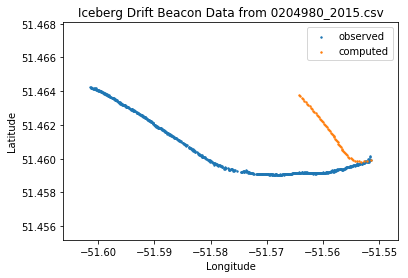

In [8]:
sim = drift_simulation.DriftSimulation(berg, ocean_data, atm_data, drift)

sim.ab2(dt, nt)

# Plot

plt.scatter(ref_berg.history['x'], ref_berg.history['y'], s=2, label='observed')
plt.scatter(sim.history['x'], sim.history['y'], s=2, label='computed')
plt.title('Iceberg Drift Beacon Data from 0204980_2015.csv')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

In [13]:
sim.berg.t + timedelta(seconds=0.1*3600)

datetime.datetime(2015, 4, 24, 15, 22, 6)

### Attempt minimization

In [10]:
min_results = minimize(drift_wrapper, x0=(1, 1), bounds=((0, 20), (0, 20)), args=(sim, ref_berg, dt, nt))
min_results

      fun: 0.005814543639000078
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.19687029e-04,  7.81588336e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 45
      nit: 11
   status: 0
  success: True
        x: array([20.        ,  3.26168913])

In [11]:
drift_wrapper(min_results.x, sim, ref_berg, dt, nt)

0.005814543639000078

### Run again with minimized values

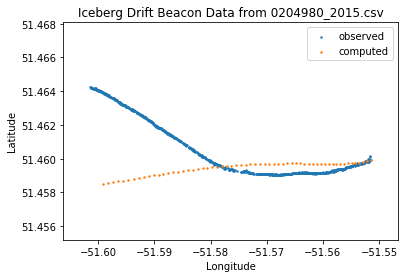

In [12]:
berg = iceberg.clone_iceberg_state(ref_berg)
sim = drift_simulation.DriftSimulation(berg, ocean_data, atm_data, drift)
sim.berg.Cda, sim.berg.Cdw = min_results.x

sim.rk2(dt, nt)

# Plot

plt.scatter(ref_berg.history['x'], ref_berg.history['y'], s=2, label='observed')
plt.scatter(sim.history['x'], sim.history['y'], s=2, label='computed')
plt.title('Iceberg Drift Beacon Data from 0204980_2015.csv')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

# Animation

### Wind

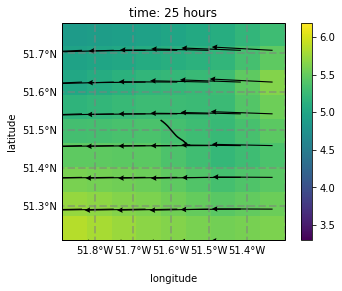

In [6]:
dx_scale = 3
dy_scale = 3
dt_scale = 3
grid_scales = [dx_scale, dy_scale, dt_scale]

x_berg = sim.history['x']
y_berg = sim.history['y']
t_berg = nc.date2num(sim.history['t'], atm_data.T_UNITS, atm_data.T_CALENDAR)
xyt_berg = [x_berg, y_berg, t_berg]

x_grid = atm_data.lons
y_grid = atm_data.lats
t_grid = atm_data.times
xyt_grid = [x_grid, y_grid, t_grid]

u_data = atm_data.U
v_data = atm_data.V
uv_data = [u_data, v_data]

plot.berg_metocean_animation(xyt_berg, xyt_grid, grid_scales, uv_data, 
                             fname='wind_anim', v_auto=True, scale=20, speed=500)

### Current

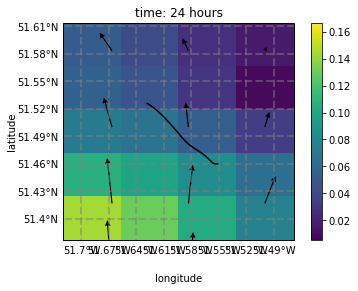

In [7]:
dx_scale = 1
dy_scale = 1
dt_scale = 1
grid_scales = [dx_scale, dy_scale, dt_scale]

x_berg = sim.history['x']
y_berg = sim.history['y']
t_berg = nc.date2num(sim.history['t'], ocean_data.T_UNITS, ocean_data.T_CALENDAR)
xyt_berg = [x_berg, y_berg, t_berg]

x_grid = ocean_data.lons
y_grid = ocean_data.lats
t_grid = ocean_data.times
xyt_grid = [x_grid, y_grid, t_grid]

u_data = ocean_data.U
v_data = ocean_data.V
uv_data = [u_data, v_data]

plot.berg_metocean_animation(xyt_berg, xyt_grid, grid_scales, uv_data, 
                             fname='current_anim', v_auto=True, scale=0.5, speed=500)

In [12]:
np.where(x_grid > -51.8)[0][0]

159

In [11]:
np.where(x_grid < -51.4)[0][-1]

163

In [13]:
np.where(y_grid > 51.4)[0][0]

137

In [14]:
np.where(y_grid < 51.7)[0][-1]

140

In [15]:
np.mean(u_data[:, 159:163+1, 137:140+1])

-0.1919608

In [16]:
np.mean(v_data[:, 159:163+1, 137:140+1])

-0.10271322

In [18]:
u2 = np.swapaxes(u_data, 1, 2)

In [19]:
np.mean(u2[:, 137:140+1,  159:163+1])

-0.1919608

In [42]:
lon0 = np.where(ocean_data.lons >= min(ref_berg.history['x']))[0][0] - 1
lonn = np.where(ocean_data.lons <= max(ref_berg.history['x']))[0][-1] + 1
lonn

162

In [43]:
lon0

160

In [44]:
lat0 = np.where(ocean_data.lats <= min(ref_berg.history['y']))[0][-1]+1
latn = np.where(ocean_data.lats >= max(ref_berg.history['y']))[0][0]+1
latn

139

In [45]:
lat0

138

In [46]:
ocean_data.lats[lat0]

51.5

In [47]:
min(ref_berg.history['y'])

51.45903

In [48]:
np.mean(ocean_data.U[:, lat0:latn+1, lon0:lonn+1])

0.004158147

In [49]:
np.mean(ocean_data.V[:, lat0:latn+1, lon0:lonn+1])

0.037465706

In [17]:
ocean_data.U

array([[[ 6.50654614e-01,  5.98162770e-01,  5.61540604e-01, ...,
          3.86364341e-01,  3.66222113e-01,  3.46079886e-01],
        [ 6.46382034e-01,  6.20746493e-01,  5.80462039e-01, ...,
          3.42417687e-01,  3.39365840e-01,  3.28379154e-01],
        [ 5.87176144e-01,  6.07318342e-01,  5.90227962e-01, ...,
          3.30820650e-01,  3.08847308e-01,  2.89315462e-01],
        ...,
        [-3.47911008e-02, -2.31940672e-02, -1.34281442e-02, ...,
         -8.97244215e-02, -1.15970336e-01, -1.35502189e-01],
        [ 0.00000000e+00,  2.44148076e-03,  3.66222113e-03, ...,
         -8.60621929e-02, -9.21659023e-02, -1.09866634e-01],
        [-6.71407208e-03, -9.76592302e-03, -9.76592302e-03, ...,
         -1.86162904e-01, -1.72124386e-01, -1.75176248e-01]],

       [[ 6.39667988e-01,  5.82903504e-01,  5.43839812e-01, ...,
          3.83312464e-01,  3.63170266e-01,  3.43028039e-01],
        [ 6.39057577e-01,  6.10370159e-01,  5.70696115e-01, ...,
          3.39976192e-01,  3.38145077e